In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, probplot
from scipy.stats.stats import pearsonr
from IPython.display import display
import sys
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.pandas.set_option('display.max_columns',None)
%matplotlib inline

In [2]:
train_df = pd.read_csv('data/train.csv', index_col='Id')
test_df = pd.read_csv('data/test.csv', index_col='Id')

In [3]:
X_train = train_df.drop(['SalePrice'], axis=1)
y_train = train_df.SalePrice

In [4]:
catCols = list(X_train.select_dtypes(include='object').columns)
f'Number of categorical variables: {len(catCols)}'

'Number of categorical variables: 43'

In [5]:
numCols = list(X_train.select_dtypes(include='number').columns)
f'Number of numerical variables: {len(numCols)}'

'Number of numerical variables: 36'

Plot Phân phối SalePrice

C:\Users\HP 840 G4\AppData\Local\Programs\Python\Python36\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


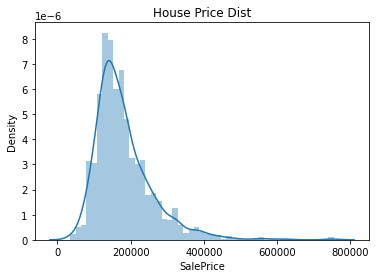

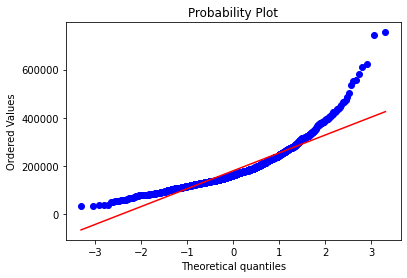

In [6]:
sns.distplot(y_train)
plt.title('House Price Dist');
fig = plt.figure()
res = probplot(y_train, plot=plt)

Nhận xét: SalePrice có dạng hơi lệch khỏi phân phối chuẩn một chút về bên phải

Chuẩn hóa đưa SalePrice về dạng normal distribution

C:\Users\HP 840 G4\AppData\Local\Programs\Python\Python36\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


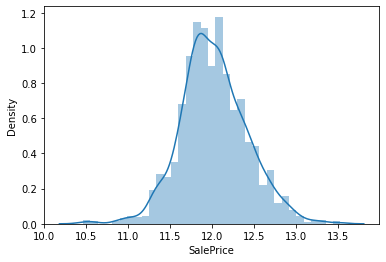

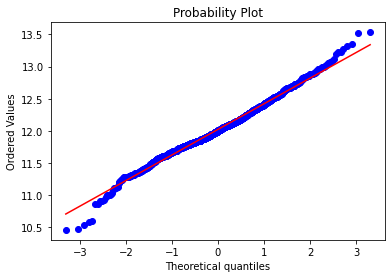

In [8]:
y_train = np.log(y_train)
sns.distplot(y_train)
fig = plt.figure()
res = probplot(y_train, plot=plt)

Nhận xét: Phân phối các giá trị của SalePrice hơi lệch phải

# Ma trận tương quan

<AxesSubplot:>

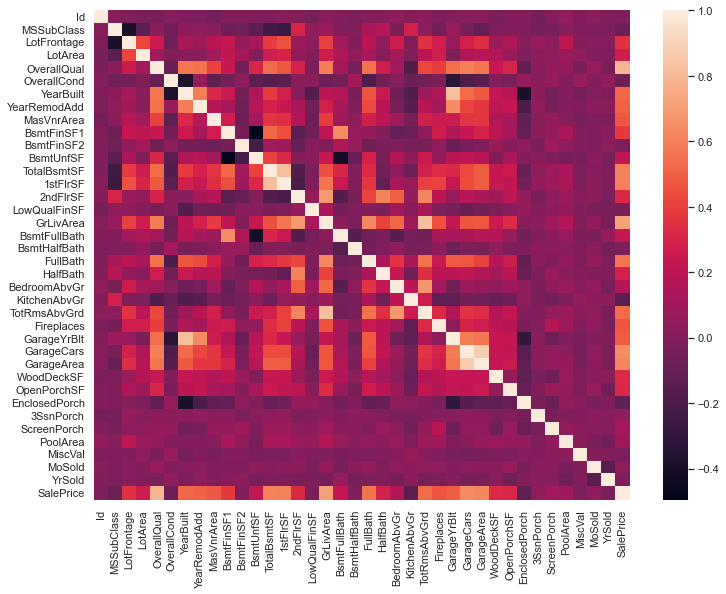

In [99]:
corr = X_train.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corr)

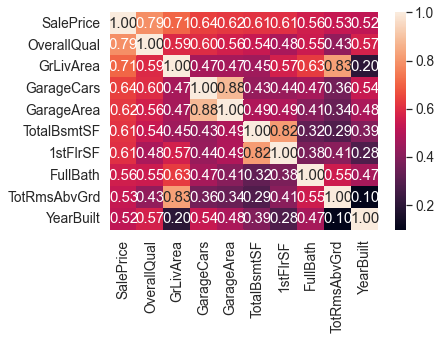

In [100]:
# 10 đặc trưng có độ tương quan lớn nhất với SalePrice
k = 10
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, annot=True,fmt='.2f', yticklabels=cols.values, xticklabels=cols.values)
plt.show();

Biện luận:
* OverallQual, GrLivArea, TotalBsmtSF tương quan nhiều với SalePrice.
* GarageCars và GarageArea khá tương đồng nhau vì diện tích Garage càng lớn thì càng để được nhiều Oto, và ngược lại, nên có thể bỏ 1 cái, giữ lại GarageCars vì có độ tương đồng với SalePrice lớn hơn.
* TotalBsmtSF và 1stFlrSF cũng khá tương đồng nhau, giữ lại TotalBsmtSF
* FullBath: Không đóng vai trò lớn trong việc quyết định giá nhà.
* TotRmsAbvGrd và GrLivArea: giá tương đồng nhau --> bỏ TotRmsAbvGrd
* Giữ lại YearBuilt: vì quan trọng trong việc quyết định giá nhà.

# PLot những đặc trưng có độ tương quan cao với SalePrice

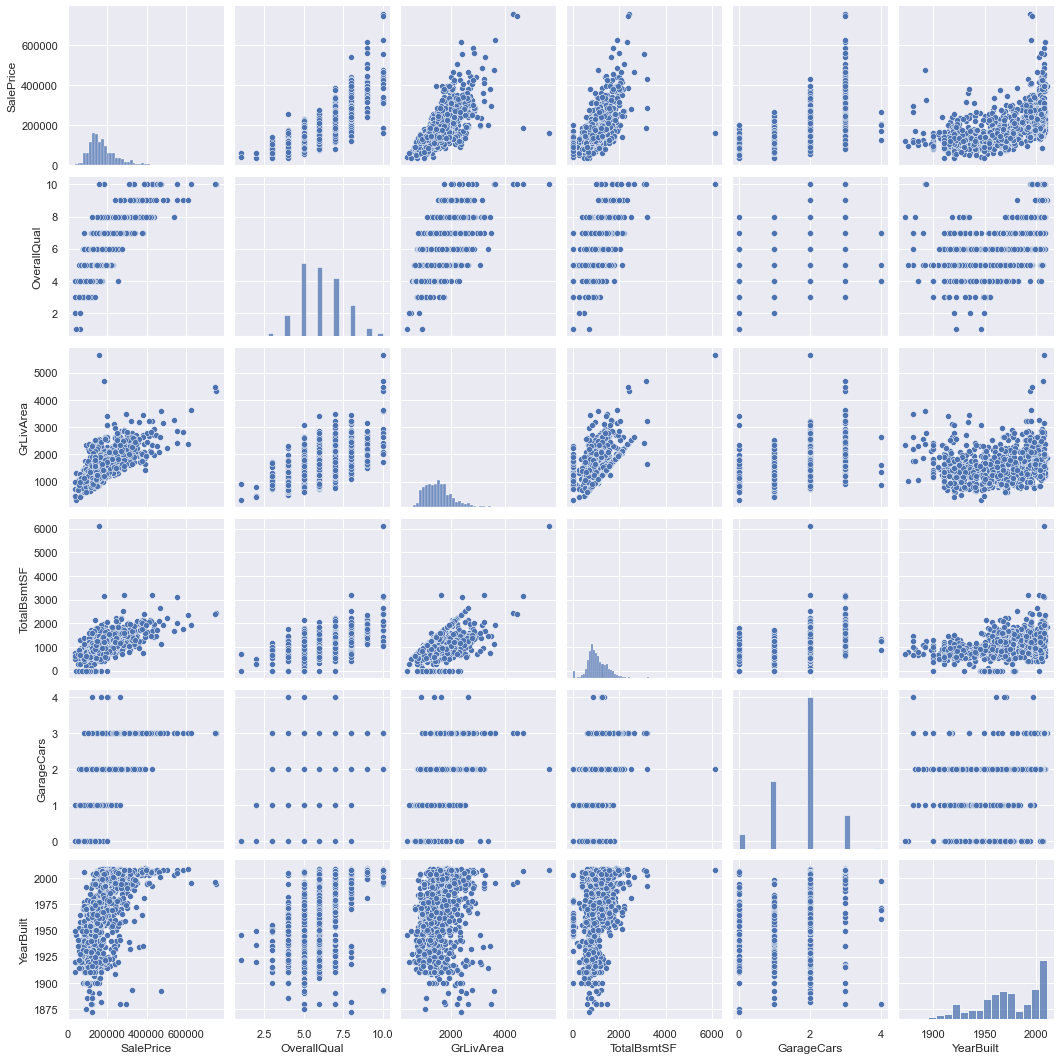

In [103]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'YearBuilt']
sns.pairplot(train_df[cols])
plt.show();

In [ ]:
trimmed_train_df = train_df[cols]

SalePrice      0
OverallQual    0
GrLivArea      0
TotalBsmtSF    0
GarageCars     0
YearBuilt      0
dtype: int64